# Import and Load

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenge1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1hzamFV4kC27mUMEV9YGWnQmv2-k5TZvo/Challenge1


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

## Load

In [ ]:
categories=np.load('categories.npy')
training_data=np.load('training_data.npy')
valid_periods=np.load('valid_periods.npy')

In [ ]:
print(categories.shape, categories.dtype)
print(training_data.shape, training_data.dtype)
print(valid_periods.shape, valid_periods.dtype)

(48000,) <U1
(48000, 2776) float64
(48000, 2) int64


In [ ]:
training_data = training_data.astype(np.float32)
int_cat = np.array([ord(char)-ord('A') for char in categories])
labels = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F'}
Size=categories.size

## Train Test split

In [ ]:
ind_train, ind_test, cat_train, cat_test = train_test_split(
    np.transpose(range(Size)),
    int_cat,
    test_size = 0.01,
    random_state = seed,
    stratify = int_cat
)
unique, count = np.unique(cat_train, return_counts=True)
print(count)
unique, count = np.unique(cat_test, return_counts=True)
print(count)

[ 5671 10877  9917  9916 10865   274]
[ 57 110 100 100 110   3]


# Base Model

##  Build the sequences

In [ ]:
def build_sequences(ind, data=training_data, periods=valid_periods, cat=int_cat, window=200, stride=20, telescope=18):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope


    for jj in ind:

      # Create padding to have the series divisible with the stride
      length=periods[jj,1]-periods[jj,0]
      pad_len=0
      if(length < WT):
        pad_len=WT-length
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj,0]:]
      padding= np.full(pad_len, 0, dtype='float32')  # zero padding

      temp_X= np.concatenate((padding,temp_X))

      assert (len(temp_X)-WT)%stride ==0


      # Create the sequences
      for idx in np.arange(0,len(temp_X)-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

In [ ]:
X_train, y_train, cat_train = build_sequences(ind_train)
X_test, y_test, cat_test = build_sequences(ind_test)

#Expand the dimensions for the LSTM layers
X_train= np.expand_dims(X_train, axis=2)
X_test= np.expand_dims(X_test, axis=2)
y_train= np.expand_dims(y_train, axis=2)
y_test= np.expand_dims(y_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((162503, 200, 1), (162503, 18, 1), (1904, 200, 1), (1904, 18, 1))

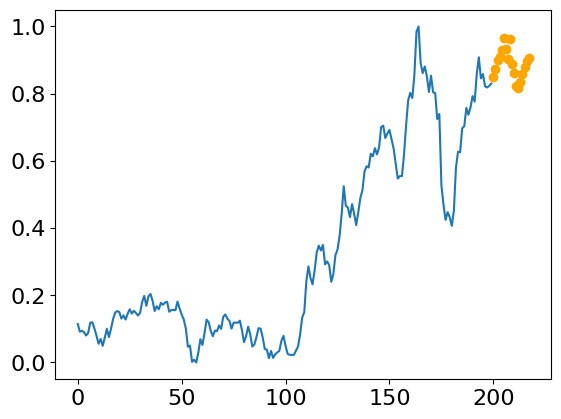

In [ ]:
#Plot one sequence with the target
telescope=18
index=10
plt.plot(np.arange(len(X_train[index,:])), X_train[index,:])
plt.scatter(np.arange(len(X_train[index,:]), len(X_train[index,:])+telescope), y_train[index,:], color='orange')
plt.show()

## Train the model

In [ ]:
#Parameters for the model
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 64 filters and a kernel size of 3
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    return model

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True, min_delta=0.00004),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-4, min_delta=0.0001)
    ]
).history

In [ ]:
#model.save('BaseModel')

In [ ]:
#Plot the history of the losses

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'][1:], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'][1:], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Predictions

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (1904, 18, 1)
Mean Squared Error: 0.008493811823427677
Mean Absolute Error: 0.059419307857751846


In [ ]:
#MSE on each category
overall=0
for c in range(6):
  test=X_test[cat_test==c]
  predictions = model.predict(test, verbose=0)
  print(f"Predictions shape: {predictions.shape}")
  mean_squared_error = tfk.metrics.mean_squared_error(y_test[cat_test==c].flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error {labels[c]}: {mean_squared_error}")
  overall = overall +mean_squared_error
print('\n')
# Since the test set is equally divided into categories this value should be closer to the real test set MSE
print(f"Mean Squared Error Finale:{overall/6}")

Predictions shape: (310, 18, 1)
Mean Squared Error A: 0.005860067438334227
Predictions shape: (298, 18, 1)
Mean Squared Error B: 0.008888805285096169
Predictions shape: (514, 18, 1)
Mean Squared Error C: 0.007555550429970026
Predictions shape: (482, 18, 1)
Mean Squared Error D: 0.010421731509268284
Predictions shape: (297, 18, 1)
Mean Squared Error E: 0.009130849502980709
Predictions shape: (3, 18, 1)
Mean Squared Error F: 0.029347600415349007


Mean Squared Error Finale:0.01186743409683307


60/60 [==============================] - 1s 13ms/step


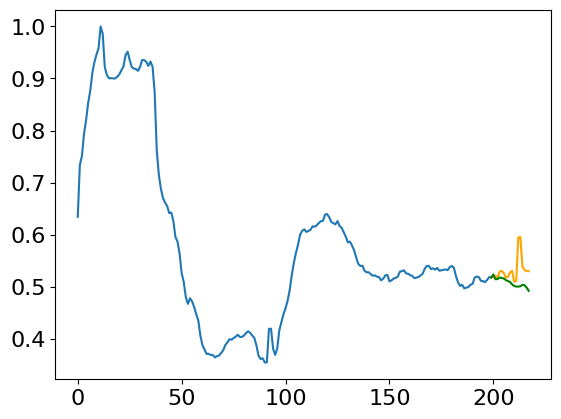

In [ ]:
# Plot the prediction and the target for a sequence

idx=6
i=0
pred = model.predict(X_test)
telescope=18

plt.plot(np.arange(len(X_test[0,:,i])), X_test[idx,:,i])
plt.plot(np.arange(len(X_test[0,:,i])-1, len(X_test[0,:,i])+telescope), np.insert(y_test[idx,:,i],0,X_test[idx,-1,i]), color='orange')
plt.plot(np.arange(len(X_test[0,:,i])-1, len(X_test[0,:,i])+telescope), np.insert(pred[idx,:,i],0,X_test[idx,-1,i]), color='green')

# Preprocessing

## Stationarity

In [ ]:
# Creating stationarity with the difference between one line and the next
dataDiff = np.diff(training_data, axis=1)
periodDiff=np.zeros(valid_periods.shape,dtype='int')
periodDiff[:,0]=valid_periods[:,0]
periodDiff[:,1]=valid_periods[:,1]-1
dataDiff.shape

In [ ]:
def build_sequences(ind, data=dataDiff, periods=periodDiff, cat=int_cat, window=48, stride=24, telescope=9):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope


    for jj in ind:
      length=periods[jj,1]-periods[jj,0]
      pad_len=0

      if(length < WT):
        pad_len=WT-length
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj,0]:]
      padding= np.full(pad_len, 0, dtype='float32')

      temp_X= np.concatenate((padding,temp_X))

      assert (len(temp_X)-WT)%stride ==0, jj


      for idx in np.arange(0,len(temp_X)-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

In [ ]:
def build_sequences_test(ind, data=training_data, periods=valid_periods, cat=int_cat, window=50, stride=25, telescope=9):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope


    for jj in ind:
      length=periods[jj,1]-periods[jj,0]
      pad_len=0

      if(length < WT):
        pad_len=WT-length
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj,0]:]
      padding= np.full(pad_len, 0, dtype='float32')

      temp_X= np.concatenate((padding,temp_X))

      assert (len(temp_X)-WT)%stride ==0, jj


      for idx in np.arange(0,len(temp_X)-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

In [ ]:
X_train, y_train, cat_train = build_sequences(ind_train)
X_test, y_test, cat_test = build_sequences_test(ind_test)

X_train= np.expand_dims(X_train, axis=2)
X_test= np.expand_dims(X_test, axis=2)
y_train= np.expand_dims(y_train, axis=2)
y_test= np.expand_dims(y_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((348112, 48, 1), (348112, 9, 1), (3597, 50, 1), (3597, 9, 1))

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True, name='gru'), name='bidirectional_lstm')(input_layer)
    #x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())   # sum of errors

    return model

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 48, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 48, 128)           25728     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 48, 64)            24640     
                                                                 
 output_layer (Conv1D)       (None, 48, 1)             193       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
Total params: 50561 (197.50 KB)
Trainable params: 50561 (197.50 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, min_delta=0.00004),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-5, min_delta=0.0001)
    ]
).history

Epoch 1/200
4896/4896 [==============================] - 77s 14ms/step - loss: 0.0058 - val_loss: 0.0053 - lr: 0.0010
Epoch 2/200
4896/4896 [==============================] - 52s 11ms/step - loss: 0.0055 - val_loss: 0.0052 - lr: 0.0010
Epoch 3/200
4896/4896 [==============================] - 55s 11ms/step - loss: 0.0054 - val_loss: 0.0051 - lr: 0.0010
Epoch 4/200
4896/4896 [==============================] - 51s 10ms/step - loss: 0.0054 - val_loss: 0.0051 - lr: 0.0010
Epoch 5/200
4896/4896 [==============================] - 48s 10ms/step - loss: 0.0054 - val_loss: 0.0051 - lr: 0.0010
Epoch 6/200
4896/4896 [==============================] - 61s 12ms/step - loss: 0.0053 - val_loss: 0.0050 - lr: 0.0010
Epoch 7/200
4896/4896 [==============================] - 48s 10ms/step - loss: 0.0053 - val_loss: 0.0049 - lr: 0.0010
Epoch 8/200
4896/4896 [==============================] - 45s 9ms/step - loss: 0.0052 - val_loss: 0.0049 - lr: 0.0010
Epoch 9/200
4896/4896 [==============================] - 

In [ ]:
#model.save('StationaryModel')

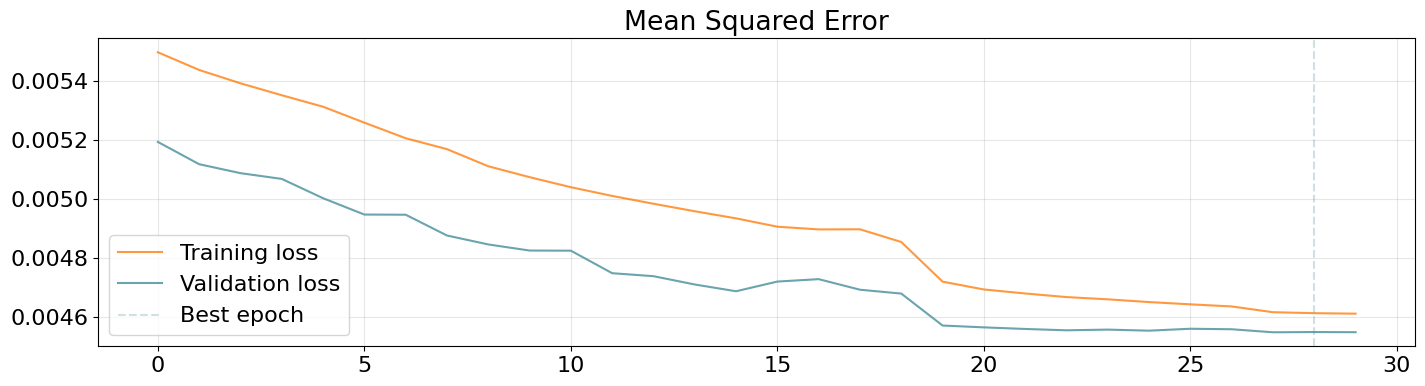

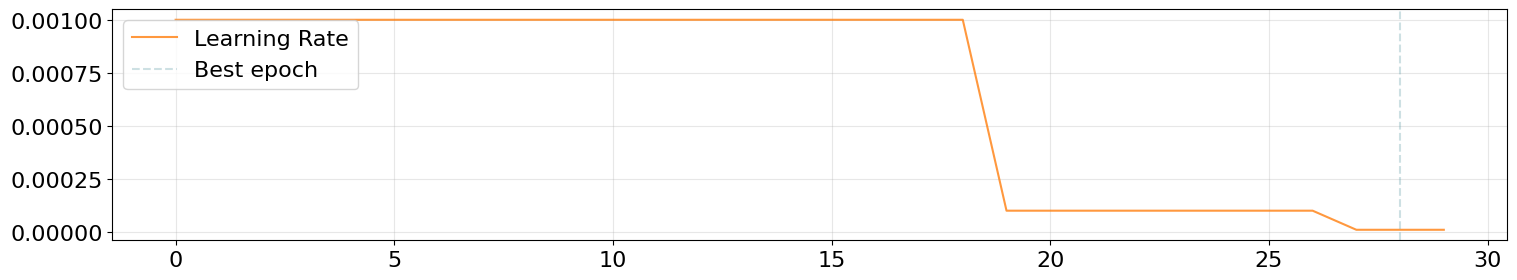

In [ ]:
#Plot the history of the losses

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'][1:], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'][1:], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
#Rewrite the prediction, since the model returns the difference between a value and next one
def Predict(input=X_test, model=model):
  X_test=input[:,-49:]
  X_test= np.diff(X_test, axis=1)
  print(X_test.shape)

  prediction = model.predict(X_test, verbose=0)
  pred=np.zeros(prediction.shape)
  length=pred.shape[1]
  X= input[:,-1]
  for jj in range(length):
    X = X + prediction[:,jj,0:1]
    pred[:,jj,0:1] = X

  return pred

In [ ]:
# Predict the test set using the model
predictions = Predict()

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

(3597, 48, 1)
Predictions shape: (3597, 9, 1)
Mean Squared Error: 0.008161162401803205
Mean Absolute Error: 0.05527473716747418


## Other stationary preprocessings

In [ ]:
# Other stationarity strategies regarded transformations
train_log = np.log(training_data)
train_sqrt = np.sqrt(training_data)
train_cbrt= np.cbrt(training_data)

# We need to normalize them
for j in range(train_log.shape[0]):
  data_2d = train_log[j].reshape(-1, 1)
  scaler = MinMaxScaler()
  normalized_data = scaler.fit_transform(data_2d)
  normalized_data_1d = normalized_data.flatten()
  log_norm[j] = normalized_data_1d

for j in range(train_sqrt.shape[0]):
  data_2d = train_sqrt[j].reshape(-1, 1)
  scaler = MinMaxScaler()
  normalized_data = scaler.fit_transform(data_2d)
  normalized_data_1d = normalized_data.flatten()
  sqrt_norm[j] = normalized_data_1d

for j in range(train_cbrt.shape[0]):
  data_2d = train_cbrt[j].reshape(-1, 1)
  scaler = MinMaxScaler()
  normalized_data = scaler.fit_transform(data_2d)
  normalized_data_1d = normalized_data.flatten()
  cbrt_norm[j] = normalized_data_1d

# Then, we used at turn calling respectively log_norm, sqrt_norm, cbrt_norm
# We tried also some mix such as differentiation + cbrt

# In addition, we tried also second order differentiation
data2Diff = np.diff(dataDiff, axis=1)
period2Diff=np.zeros(periodDff.shape,dtype='int')
period2Diff[:,0]=periodDiff[:,0]
period2Diff[:,1]=periodDiff[:,1]-1
data2Diff.shape
# as before we adapted the model

## Smoothing

In [ ]:
# Autoregression, AR of ARIMA
# Doing AR
def add_autoregressive_component(data, p):
    n, l = data.shape
    for i in range(n):
        for lag in range(1, p + 1):
            data[i, lag:] += 0.5 * data[i, :-lag]  # Add autoregressive component
    return data

# Add autoregressive component with order p=2
order_of_autoregression = 1 # decided
datasetAR = add_autoregressive_component(dataset.copy(), order_of_autoregression)


# Rolling statistics, both mean and std_dev

window_size = 10
# Calculate rolling mean
train_roll_mean = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='valid'), axis=0, arr=time_series_data)
# Calculate rolling standard deviation
train_roll_std_dev = np.apply_along_axis(lambda x: np.sqrt(np.convolve(x**2, np.ones(window_size)/window_size, mode='valid') - (np.convolve(x, np.ones(window_size)/window_size, mode='valid'))**2), axis=0, arr=time_series_data)


## Padding

In [ ]:
def build_sequences_skip(ind, data=training_data, periods=valid_periods, cat=int_cat, window=200, stride=20, telescope=9):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope


    for jj in ind:
      length=periods[jj,1]-periods[jj,0]
      pad_len=0

      if(length < WT):  #No padding, skip all the sequneces below window + telescope (209)
        continue
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj,0]:]
      padding= np.full(pad_len, 0, dtype='float32')

      temp_X= np.concatenate((padding,temp_X))

      assert (len(temp_X)-WT)%stride ==0


      for idx in np.arange(stride,len(temp_X)-WT+1,stride):  #we start from stride to avoid the first one with padding
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

In [ ]:
def build_sequences_mirror(ind, data=training_data, periods=valid_periods, cat=int_cat, window=40, stride=20, telescope=9):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope


    for jj in ind:
      length=periods[jj,1]-periods[jj,0]
      pad_len=0

      if(length < WT):
        pad_len=WT-length
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj,0]:]

      if pad_len > length:
        pad_len=pad_len-length
        temp_X = np.concatenate((temp_X[::-1], temp_X))  #flip the data and concatenate

      temp_X=np.concatenate((temp_X[:pad_len][::-1], temp_X))

      assert (len(temp_X)-WT)%stride ==0


      for idx in np.arange(0,len(temp_X)-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

In [ ]:
def build_sequences_period(ind, data=training_data, periods=valid_periods, cat=int_cat, window=40, stride=20, telescope=9):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope


    for jj in ind:
      length=periods[jj,1]-periods[jj,0]
      pad_len=0

      if(length < WT):
        pad_len=WT-length
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj,0]:]

      #Keep adding the first period as long as a period fits
      while pad_len >=12:
        pad_len=pad_len-12
        temp_X = np.concatenate((temp_X[:12], temp_X))

      #Add the remaining
      temp_X = np.concatenate((temp_X[12-pad_len:12], temp_X))

      assert (len(temp_X)-WT)%stride ==0


      for idx in np.arange(0,len(temp_X)-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

In [ ]:
def build_sequences_mean(ind, data=training_data, periods=valid_periods, cat=int_cat, window=40, stride=20, telescope=9):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope


    for jj in ind:
      length=periods[jj,1]-periods[jj,0]
      pad_len=0

      if(length < WT):
        pad_len=WT-length
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj,0]:]
      padding= np.full(pad_len, np.mean(temp_X), dtype='float32')

      temp_X= np.concatenate((padding,temp_X))

      assert (len(temp_X)-WT)%stride ==0


      for idx in np.arange(0,len(temp_X)-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

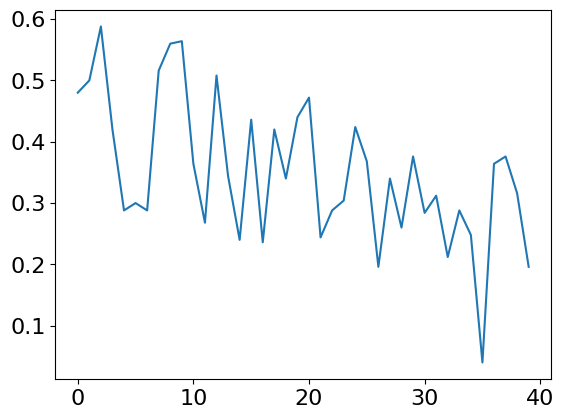

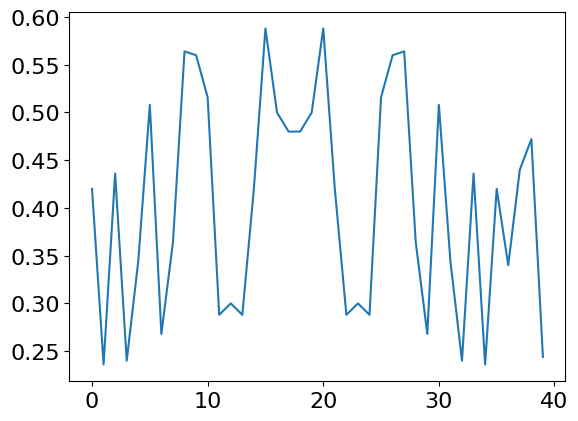

In [ ]:
# mirror padding
window=40
index=1
my_array=training_data[index,valid_periods[index,0]:valid_periods[index,0]+window]
result_arrays,a,b = build_sequences_mirror(np.transpose(range(index,index+1)))
plt.plot(my_array)
plt.show()
plt.plot(result_arrays[0])
plt.show()

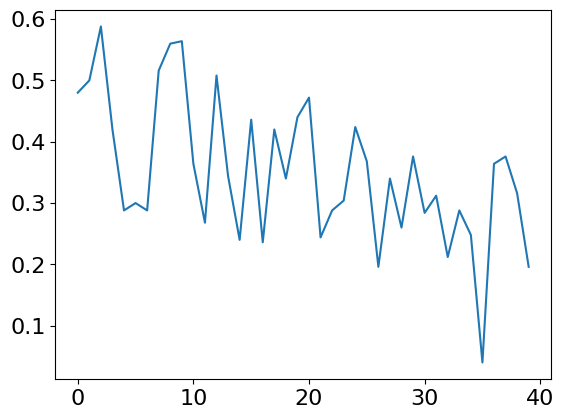

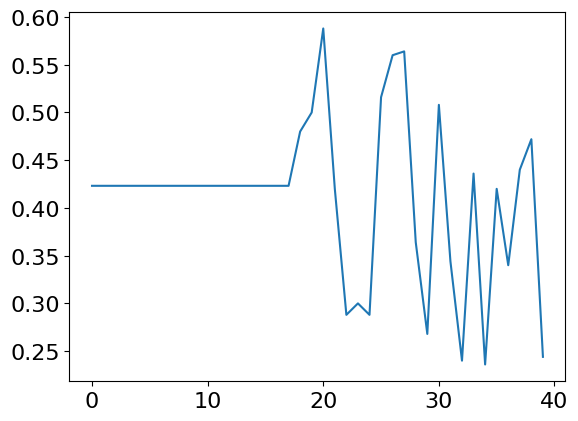

In [ ]:
# mean padding
window=40
index=1
my_array=training_data[index,valid_periods[index,0]:valid_periods[index,0]+window]
result_arrays,a,b = build_sequences_mean(np.transpose(range(index,index+1)))
plt.plot(my_array)
plt.show()
plt.plot(result_arrays[0])
plt.show()

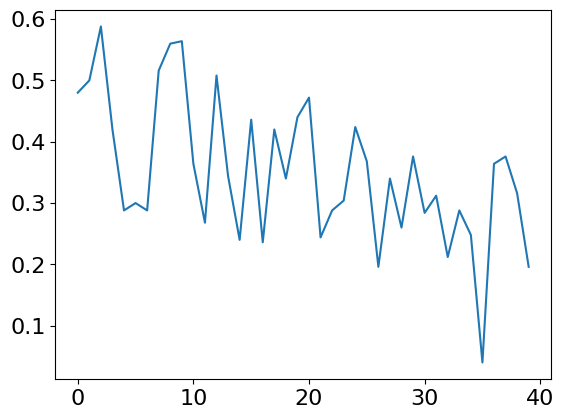

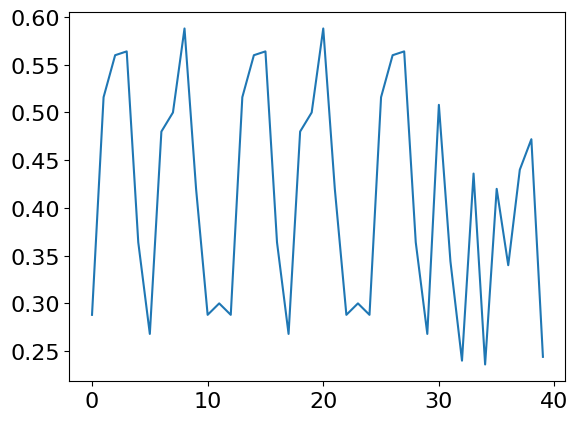

In [ ]:
# period padding
window=40
index=1
my_array=training_data[index,valid_periods[index,0]:valid_periods[index,0]+window]
result_arrays,a,b = build_sequences_period(np.transpose(range(index,index+1)))
plt.plot(my_array)
plt.show()
plt.plot(result_arrays[0])
plt.show()

# Everything else


## Autoregressive

In [ ]:
autoTelescope=9
# Load a model that predicts autoTelescope
model= tfk.models.load_model('baseModel9')

In [ ]:
# Autoregressive Forecasting
telescope=18

reg_predictions = np.array([])
X_temp = X_test
for reg in range(0,telescope,autoTelescope):
    pred_temp = model.predict(X_temp,verbose=0)[:,:autoTelescope, 0]
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,autoTelescope:],pred_temp), axis=1)

In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error Auto: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error Auto: {mean_absolute_error}")

## Custom self attention

### Additive attention


In [ ]:
# Attention block
def additive_attention(query, key, value):
    score = tfkl.Concatenate(axis=-1)([query, key])
    score = tfkl.Dense(units=64, activation='tanh')(score)
    score = tfkl.Dense(units=1, activation=None)(score)
    attention_weights = tfkl.Activation('softmax')(score)
    # Repeat attention weights along the time axis to match the number of time steps
    attention_weights = tfkl.RepeatVector(tf.shape(query)[1])(attention_weights)
    attention_output = tfkl.Dot(axes=[1, 1])([attention_weights, value])
    return attention_output

# We also tried other different combinations, this is one them

In [ ]:
def build_CONV_LSTM_model_with_attention(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise, we want input time steps to be >= output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    lstm = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True, name='gru'), name='bidirectional_lstm')(input_layer)

    # Attention mechanism
    attention_output = additive_attention(lstm, lstm, lstm)

    # Concatenate the attention output with the LSTM output
    conc = tfkl.Concatenate(axis=-1)([lstm, attention_output])

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(conc)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model_with_attention')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model_additive_attention

### Self attention with positional encoding

In [ ]:
# Attention block

def positional_encoding(inputs):
    position = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1, dtype=tf.float32)
    position = tf.expand_dims(position, axis=-1)
    position /= 10000.0
    position_encoding = tf.math.sin(position / tf.pow(10000.0, 2 * tf.range(start=0, limit=inputs.shape[-1], delta=2, dtype=tf.float32) / tf.cast(inputs.shape[-1], tf.float32)))
    return position_encoding

def self_attention_with_positional_encoding(query, key, value):
    query_encoding = positional_encoding(query)
    key_encoding = positional_encoding(key)
    value_encoding = positional_encoding(value)

    query_with_encoding = tfkl.Add()([query, query_encoding])
    key_with_encoding = tfkl.Add()([key, key_encoding])
    value_with_encoding = tfkl.Add()([value, value_encoding])

    return scaled_dot_product_attention(query_with_encoding, key_with_encoding, value_with_encoding)

In [ ]:
def build_CONV_LSTM_model_with_attention(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise, we want input time steps to be >= output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    lstm = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True, name='gru'), name='bidirectional_lstm')(input_layer)

    # Attention mechanism
    attention_output = self_attention_with_positional_encoding(lstm, lstm, lstm)

    # Concatenate the attention output with the LSTM output
    conc = tfkl.Concatenate(axis=-1)([lstm, attention_output])

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(conc)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model_with_attention')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model_self_attention

## Time to vec embedding

In [ ]:
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(Time2Vec, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        # Define weights for the Time2Vec layer
        self.W = self.add_weight(name='W_time2vec',
                                 shape=(int(input_shape[-1]), self.output_dim),
                                 initializer='uniform',
                                 trainable=True)
        self.P = self.add_weight(name='P_time2vec',
                                 shape=(int(input_shape[-1]), self.output_dim),
                                 initializer='uniform',
                                 trainable=True)
        self.w0 = self.add_weight(name='w0_time2vec',
                                  shape=(self.output_dim,),
                                  initializer='uniform',
                                  trainable=True)
        self.p0 = self.add_weight(name='p0_time2vec',
                                  shape=(self.output_dim,),
                                  initializer='uniform',
                                  trainable=True)

    def call(self, x):
        # Extract time-related features
        t = x
        # Apply Time2Vec transformation
        return self.w0 * tf.math.cos(tf.matmul(t, self.W)) + self.p0 * tf.math.sin(tf.matmul(t, self.P))

def build_CONV_LSTM_model_with_attention_and_time2vec(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise, we want input time steps to be >= output time steps"

    # Define the input layer with the specified shape
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

    # Extract time-related features (assuming it's in the first column)
    time_features = input_layer[:, :, :1]
    other_features = input_layer[:, :, 1:]

    # Apply Time2Vec to time-related features
    time2vec_output = Time2Vec(output_dim=64)(time_features)

    # Concatenate Time2Vec output with other features
    concatenated_input = tf.keras.layers.Concatenate(axis=-1)([time2vec_output, other_features])

    # Add a Bidirectional LSTM layer with 64 units
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True, name='gru'), name='bidirectional_lstm')(concatenated_input)

    # Attention mechanism
    attention_output = tfkl.MultiHeadAttention(4, 64//4, value_dim=None)(lstm, lstm, lstm)

    # Concatenate the attention output with the LSTM output
    conc = tfkl.Concatenate(axis=-1)([lstm, attention_output])

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu', name='conv')(conc)
    x = tf.keras.layers.SpatialDropout1D(0.2)(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tf.keras.layers.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tf.keras.layers.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model_with_attention_and_time2vec')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model_time2vec

# we used the following in the train part

## Fourier splitting

### Plot Fourier

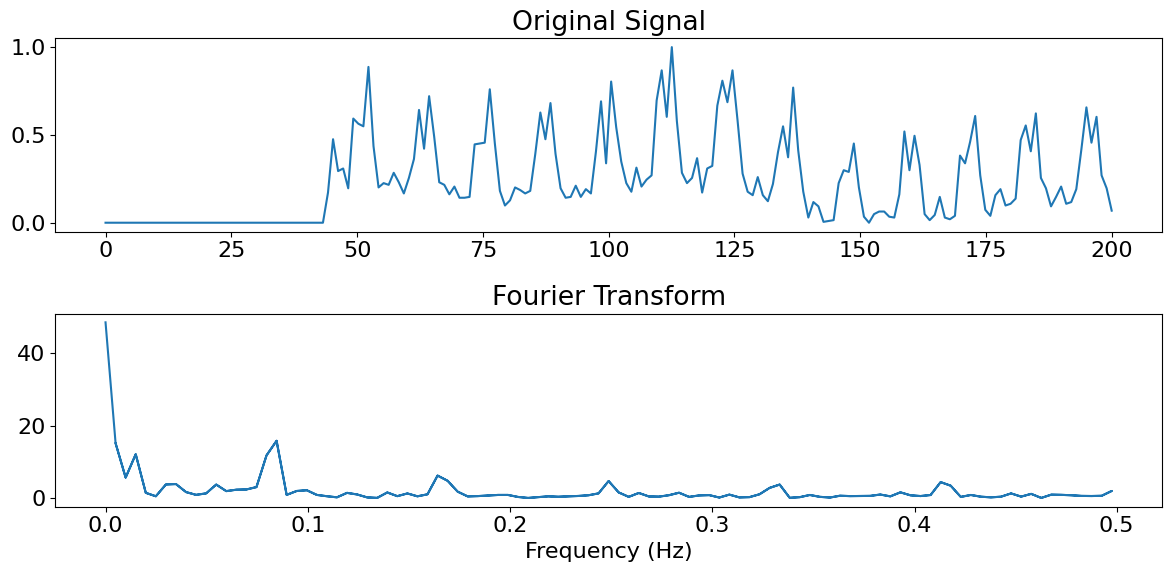

In [ ]:
index=20
signal=training_data[index,-200:]
time = np.linspace(0, signal.size, signal.size)  # Replace with your actual time values

# Compute the Fourier transform
fourier_transform = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=(time[1] - time[0]))

# Plot the original signal and its Fourier transform
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(np.abs(frequencies), np.abs(fourier_transform))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

time_interval = 1

time_series_list=training_data[:10,-40:]

# Calculate the Fourier transform for each time series
fourier_transforms = [np.fft.fft(ts) for ts in time_series_list]

# Calculate the corresponding frequencies
frequencies = np.fft.fftfreq(len(time_series_list[0]), d=time_interval)

# Define the frequency corresponding to a one-year period
one_year_frequency = 1 / 12  # 1 cycle per 12 months

# Identify indices corresponding to the one-year period frequencies
indices_one_year_period = np.where(np.isclose(frequencies, one_year_frequency, rtol=0.03))

# Classify time series based on amplitude at the one-year period frequencies
threshold_amplitude = 3 # Set your threshold for amplitude

for i, fourier_transform in enumerate(fourier_transforms):
    amplitude_at_one_year_period = np.abs(fourier_transform[indices_one_year_period])
    if amplitude_at_one_year_period > threshold_amplitude:
        print(f"Time series {i }: Has high amplitude for one-year period")
    else:
        print(f"Time series {i }: Does not have high amplitude for one-year period")


Time series 0: Does not have high amplitude for one-year period
Time series 1: Does not have high amplitude for one-year period
Time series 2: Does not have high amplitude for one-year period
Time series 3: Does not have high amplitude for one-year period
Time series 4: Does not have high amplitude for one-year period
Time series 5: Does not have high amplitude for one-year period
Time series 6: Does not have high amplitude for one-year period
Time series 7: Does not have high amplitude for one-year period
Time series 8: Does not have high amplitude for one-year period
Time series 9: Does not have high amplitude for one-year period


### Build sequences and Split fourier

In [ ]:
# Without padding

def build_sequences(ind, data=training_data, periods=valid_periods, cat=int_cat, window=200, stride=20, telescope=9):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope

    buttate=0

    for jj in ind:
      length=periods[jj,1]-periods[jj,0]
      if(length < WT):
        buttate=buttate+1
        continue
      length= length - (length-WT)%stride
      temp_X = data[jj,-length:]

      for idx in np.arange(0,length-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    print('saltete ',buttate, 'sequenze perchè inferiori di', WT)
    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

In [ ]:
X_train, y_train, cat_train = build_sequences(ind_train)
X_test, y_test, cat_test = build_sequences(ind_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

saltete  25267 sequenze perchè inferiori di 209
saltete  763 sequenze perchè inferiori di 209


((121389, 200), (121389, 9), (4159, 200), (4159, 9))

In [ ]:
time_interval = 1
data=X_train
scaler = MinMaxScaler()
# Apply Min-Max scaling to each row
time_series_list = scaler.fit_transform(data.T).T

fourier_transforms = [np.fft.fft(ts) for ts in time_series_list]

# Calculate the corresponding frequencies
frequencies = np.fft.fftfreq(len(time_series_list[0]), d=time_interval)
fourier_transforms= [fourier_trans[frequencies>=0] for fourier_trans in fourier_transforms]
frequencies=frequencies[frequencies>=0]

# Define the frequency corresponding to a one-year period
# Define the frequency corresponding to a one-year period
year_frequency = np.array([1 / 12, 1/6])   # 1 cycle per 12 months

# Identify indices corresponding to the one-year period frequencies
indices_year_period = np.where(np.isclose(frequencies, year_frequency[0], rtol=0.15) | np.isclose(frequencies, year_frequency[1], rtol=0.05))[0]
# Classify time series based on amplitude at the one-year period frequencies
threshold_amplitude = 5 # Set your threshold for amplitude

count=0
Periodiche=np.full(time_series_list.shape[0],False)

for i, fourier_transform in enumerate(fourier_transforms):
    amplitude_at_year_period = np.abs(fourier_transform[indices_year_period])
    if amplitude_at_year_period[0]+amplitude_at_year_period[1] > threshold_amplitude:
      Periodiche[i]=True
      count=count+1
print('numero di sequenze periodiche', count, 'su', time_series_list.shape[0])

numero di sequenze periodiche 35859 su 121389


In [ ]:
time_interval = 1
data=X_test
scaler = MinMaxScaler()
# Apply Min-Max scaling to each row
time_series_list = scaler.fit_transform(data.T).T
fourier_transforms = [np.fft.fft(ts) for ts in time_series_list]

# Calculate the corresponding frequencies
frequencies = np.fft.fftfreq(len(time_series_list[0]), d=time_interval)
fourier_transforms= [fourier_trans[frequencies>=0] for fourier_trans in fourier_transforms]
frequencies=frequencies[frequencies>=0]

# Define the frequency corresponding to a one-year period
year_frequency = np.array([1 / 12, 1/6])   # 1 cycle per 12 months

# Identify indices corresponding to the one-year period frequencies
indices_year_period = np.where(np.isclose(frequencies, year_frequency[0], rtol=0.15) | np.isclose(frequencies, year_frequency[1], rtol=0.05))[0]
# Classify time series based on amplitude at the one-year period frequencies
threshold_amplitude = 8 # Set your threshold for amplitude

count=0
PeriodicheTest=np.full(time_series_list.shape[0],False)

for i, fourier_transform in enumerate(fourier_transforms):
    amplitude_at_year_period = np.abs(fourier_transform[indices_year_period])
    if amplitude_at_year_period[0]+amplitude_at_year_period[1] > threshold_amplitude:
      PeriodicheTest[i]=True
      count=count+1
print('numero di sequenze periodiche', count, 'su', time_series_list.shape[0])

numero di sequenze periodiche 362 su 4159


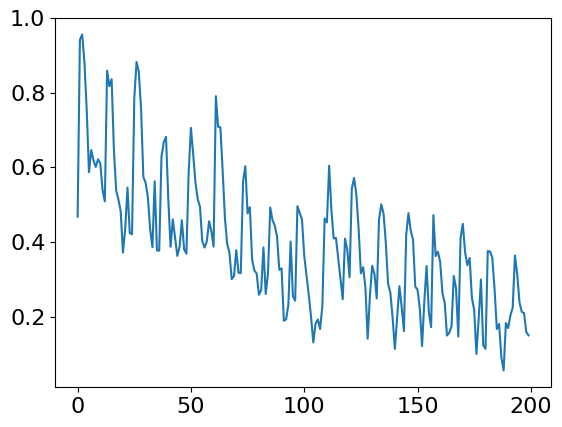

In [ ]:
index=90
data=X_test[PeriodicheTest]
plt.plot(data[index])

In [ ]:
X_train1= np.expand_dims(X_train, axis=2)
y_train1= np.expand_dims(y_train, axis=2)
X_test1= np.expand_dims(X_test, axis=2)
y_test1= np.expand_dims(y_test, axis=2)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_F=X_train1[Periodiche]
X_train_NF=X_train1[~Periodiche]
X_test_F=X_test1[PeriodicheTest]
X_test_NF=X_test1[~PeriodicheTest]
y_train_F=y_train1[Periodiche]
y_train_NF=y_train1[~Periodiche]
y_test_F=y_test1[PeriodicheTest]
y_test_NF=y_test1[~PeriodicheTest]
cat_train_F=cat_train[Periodiche]
cat_train_NF=cat_train[~Periodiche]
cat_test_F=cat_test[PeriodicheTest]
cat_test_NF=cat_test[~PeriodicheTest]

print(X_train_F.shape, y_train_F.shape, X_test_F.shape, y_test_F.shape)
print(X_train_NF.shape, y_train_NF.shape, X_test_NF.shape, y_test_NF.shape)

(121389, 200) (121389, 9) (4159, 200) (4159, 9)
(35859, 200, 1) (35859, 9, 1) (362, 200, 1) (362, 9, 1)
(85530, 200, 1) (85530, 9, 1) (3797, 200, 1) (3797, 9, 1)


### Model Fourier Fine Tuning

In [ ]:
X_train = X_train_F
y_train=y_train_F
X_test = X_test_F
y_test=y_test_F
cat_train=cat_train_F
cat_test=cat_test_F

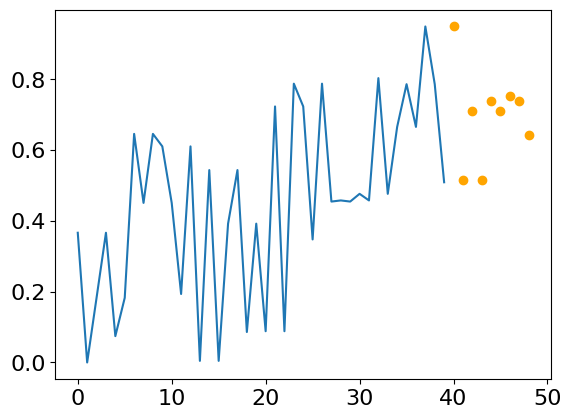

In [ ]:
telescope=9
indice=10
plt.plot(np.arange(len(X_train[indice,:])), X_train[indice,:])
plt.scatter(np.arange(len(X_train[indice,:]), len(X_train[indice,:])+telescope), y_train[indice,:], color='orange')

In [ ]:
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

# Load your pre-trained model
pretrained_model = tfk.models.load_model('NewGru_40_20')
pretrained_model.trainable=False

# Remove the last two layers
pretrained= tfk.models.Model(inputs=pretrained_model.inputs, outputs=pretrained_model.layers[-4].output)

# Add a new convolutional layer
x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv')(pretrained.output)
output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

# Calculate the size to crop from the output to match the output shape
crop_size = output_layer.shape[1] - output_shape[0]

# Crop the output to the desired length
output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)


# Build the new model
model = tfk.models.Model(inputs=pretrained_model.inputs, outputs=output_layer)


# Compile and train the new model as needed
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 40, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 40, 128)           25728     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 40, 64)            24640     
                                                                 
 output_layer (Conv1D)       (None, 40, 1)             193       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
Total params: 50561 (197.50 KB)
Trainable params: 24833 (97.00 KB)
Non-trainable params: 25728 (100.50 KB)
__________________

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True, min_delta=0.00004)
    ]
).history

Epoch 1/200
402/402 [==============================] - 10s 8ms/step - loss: 0.0166 - val_loss: 0.0150
Epoch 2/200
402/402 [==============================] - 2s 6ms/step - loss: 0.0143 - val_loss: 0.0147
Epoch 3/200
402/402 [==============================] - 2s 5ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 4/200
402/402 [==============================] - 3s 7ms/step - loss: 0.0137 - val_loss: 0.0140
Epoch 5/200
402/402 [==============================] - 3s 7ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 6/200
402/402 [==============================] - 2s 5ms/step - loss: 0.0134 - val_loss: 0.0138
Epoch 7/200
402/402 [==============================] - 2s 5ms/step - loss: 0.0132 - val_loss: 0.0147
Epoch 8/200
402/402 [==============================] - 2s 6ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 9/200
402/402 [==============================] - 2s 5ms/step - loss: 0.0131 - val_loss: 0.0137
Epoch 10/200
402/402 [==============================] - 3s 7ms/step - loss: 0.0131 - val_l

In [ ]:
model.trainable=True
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.0001))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 40, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 40, 128)           25728     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 40, 64)            24640     
                                                                 
 output_layer (Conv1D)       (None, 40, 1)             193       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
Total params: 50561 (197.50 KB)
Trainable params: 50561 (197.50 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True, min_delta=0.00004)
    ]
).history

Epoch 1/200
402/402 [==============================] - 9s 10ms/step - loss: 0.0122 - val_loss: 0.0132
Epoch 2/200
402/402 [==============================] - 3s 8ms/step - loss: 0.0121 - val_loss: 0.0132
Epoch 3/200
402/402 [==============================] - 4s 11ms/step - loss: 0.0121 - val_loss: 0.0132
Epoch 4/200
402/402 [==============================] - 4s 9ms/step - loss: 0.0120 - val_loss: 0.0132
Epoch 5/200
402/402 [==============================] - 3s 8ms/step - loss: 0.0120 - val_loss: 0.0132
Epoch 6/200
402/402 [==============================] - 3s 8ms/step - loss: 0.0120 - val_loss: 0.0132
Epoch 7/200
402/402 [==============================] - 4s 11ms/step - loss: 0.0119 - val_loss: 0.0132
Epoch 8/200
402/402 [==============================] - 4s 9ms/step - loss: 0.0119 - val_loss: 0.0132
Epoch 9/200
402/402 [==============================] - 3s 8ms/step - loss: 0.0119 - val_loss: 0.0132


In [ ]:
#model.save('FourierTransfSplitF')
#modello = tfk.models.load_model('NewGru_40_20')

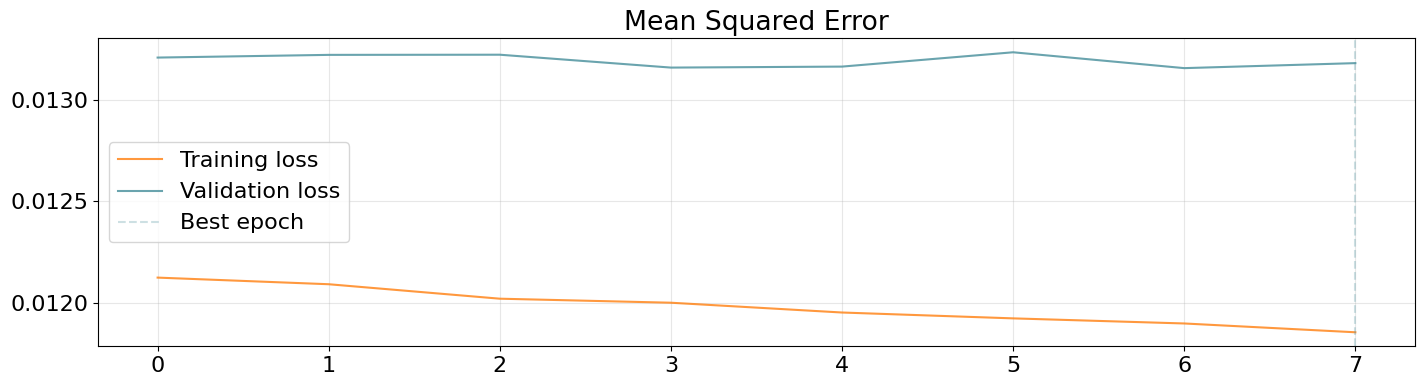

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'][1:], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'][1:], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (2212, 9, 1)
Mean Squared Error: 0.013198288157582283
Mean Absolute Error: 0.07917618751525879


In [ ]:
#MSE on each category
for c in range(6):
  test=X_test[cat_test==c]
  predictions = model.predict(test, verbose=0)
  print(f"Predictions shape: {predictions.shape}")
  mean_squared_error = tfk.metrics.mean_squared_error(y_test[cat_test==c].flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error:{labels[c]}: {mean_squared_error}")

In [ ]:
idx=16
i=0
pred = model.predict(X_test)
telescope=9

plt.plot(np.arange(len(X_test[0,:,i])), X_test[idx,:,i])
plt.plot(np.arange(len(X_test[0,:,i])-1, len(X_test[0,:,i])+telescope), np.insert(y_test[idx,:,i],0,X_test[idx,-1,i]), color='orange')
plt.plot(np.arange(len(X_test[0,:,i])-1, len(X_test[0,:,i])+telescope), np.insert(pred[idx,:,i],0,X_test[idx,-1,i]), color='green')

In [ ]:
base_model = tfk.models.load_model('NewGru_40_20')

In [ ]:
# Predict the test set using the model
predictions = base_model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
#MSE on each category
for c in range(6):
  test=X_test[cat_test==c]
  predictions = base_model.predict(test, verbose=0)
  print(f"Predictions shape: {predictions.shape}")
  mean_squared_error = tfk.metrics.mean_squared_error(y_test[cat_test==c].flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error:{labels[c]}: {mean_squared_error}")

### Model Non Fourier Fine Tuning

In [ ]:
X_train = X_train_NF
y_train=y_train_NF
X_test = X_test_NF
y_test=y_test_NF
cat_train=cat_train_NF
cat_test=cat_test_NF

In [ ]:
telescope=9
indice=10
plt.plot(np.arange(len(X_train[indice,:])), X_train[indice,:])
plt.scatter(np.arange(len(X_train[indice,:]), len(X_train[indice,:])+telescope), y_train[indice,:], color='orange')

In [ ]:
model = tfk.models.load_model('NewGru_40_20')
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))
batch_size = 64
epochs = 200

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True, min_delta=0.00004),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-4, min_delta=0.0001)
    ]
).history

In [ ]:
model.save('FourierTransfSplitNF')
#model = tfk.models.load_model('NewBaseline')

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'][1:], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'][1:], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'][1:], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
#MSE on each category
for c in range(6):
  test=X_test[cat_test==c]
  predictions = model.predict(test, verbose=0)
  print(f"Predictions shape: {predictions.shape}")
  mean_squared_error = tfk.metrics.mean_squared_error(y_test[cat_test==c].flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error:{labels[c]}: {mean_squared_error}")

In [ ]:
idx=6
i=0
pred = model.predict(X_test)
telescope=9

plt.plot(np.arange(len(X_test[0,:,i])), X_test[idx,:,i])
plt.plot(np.arange(len(X_test[0,:,i])-1, len(X_test[0,:,i])+telescope), np.insert(y_test[idx,:,i],0,X_test[idx,-1,i]), color='orange')
plt.plot(np.arange(len(X_test[0,:,i])-1, len(X_test[0,:,i])+telescope), np.insert(pred[idx,:,i],0,X_test[idx,-1,i]), color='green')

## Upsampling of category F

### Mix-up

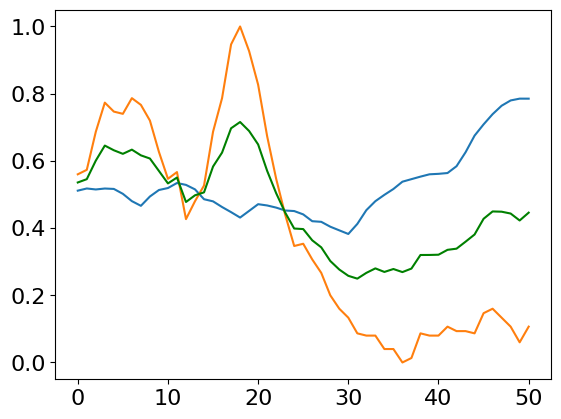

In [ ]:
index1=100
index2=10000
period=max(valid_periods[index1,0],valid_periods[index2,0])
a=training_data[index1, period:]
b=training_data[index2, period:]
c=0.5*a+0.5*b
plt.plot(a)
plt.plot(b)
plt.plot(c, color = 'green')

In [ ]:
X0=training_data[ind_train[cat_train==5]]
p0=valid_periods[ind_train[cat_train==5],0]

dataset=X0
periods=p0

for ii in range(1,X0.shape[0]):
  skip=np.random.uniform()
  if skip<0.67:
    continue

  X=np.concatenate([X0[ii:], X0[0:ii]], axis=0)
  p=np.concatenate([p0[ii:], p0[0:ii]], axis=0)
  lam = np.random.uniform(0.25, 0.75)
  sig = np.random.choice([-1, 1])
  X1=sig*(1-lam)*X0-sig*lam*X
  p1=np.maximum(p0,p)
  dataset=np.concatenate([dataset,X1], axis=0)
  periods=np.concatenate([periods,p1], axis=0)


scaler = MinMaxScaler()
dataset=scaler.fit_transform(dataset.T).T
dataset.shape, periods.shape

((23564, 2776), (23564,))

In [ ]:
dataset=np.concatenate([training_data[ind_train[cat_train!=5]], dataset], axis=0)
periods=np.concatenate([valid_periods[ind_train[cat_train!=5],0], periods], axis=0)
dataset.shape, periods.shape

((70810, 2776), (70810,))

In [ ]:
def build(data=dataset, periods=periods, window=120, telescope=18):

    dataset=[]
    Y = []
    WT=window+telescope

    for jj in range(periods.size):
      temp_X = data[jj,periods[jj]:]
      length=2776-periods[jj]
      if(length < WT):
        pad_len=WT-length
        padding= np.full(pad_len, 0, dtype='float32')
        temp_X= np.concatenate((padding,temp_X))

      dataset.append(temp_X[-WT:-telescope])
      Y.append(temp_X[-telescope:])

    dataset = np.array(dataset)
    Y = np.array(Y)
    return dataset, Y

In [ ]:
def build_sequences_zero(ind, data=training_data, periods=valid_periods, cat=int_cat, window=200, stride=20, telescope=18):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []
    categories=[]

    WT=window+telescope


    for jj in ind:
      length=periods[jj,1]-periods[jj,0]
      pad_len=0

      if(length < WT):
        pad_len=WT-length
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj,0]:]
      padding= np.full(pad_len, 0, dtype='float32')

      temp_X= np.concatenate((padding,temp_X))

      assert (len(temp_X)-WT)%stride ==0


      for idx in np.arange(0,len(temp_X)-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])
        categories.append(cat[jj])

    dataset = np.array(dataset)
    Y = np.array(Y)
    categories = np.array(categories)
    return dataset, Y, categories

In [ ]:
def build_sequences_zero_train(data=dataset, periods=periods, window=200, stride=20, telescope=18):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset=[]
    Y = []

    WT=window+telescope


    for jj in range(periods.size):
      length=2776-periods[jj]
      pad_len=0

      if(length < WT):
        pad_len=WT-length
      elif (length-WT)%stride !=0 :
        pad_len=stride - (length-WT)%stride

      temp_X = data[jj,periods[jj]:]
      padding= np.full(pad_len, 0, dtype='float32')

      temp_X= np.concatenate((padding,temp_X))

      assert (len(temp_X)-WT)%stride ==0


      for idx in np.arange(0,len(temp_X)-WT+1,stride):
        dataset.append(temp_X[idx:idx+window])
        Y.append(temp_X[idx+window:idx+WT])

    dataset = np.array(dataset)
    Y = np.array(Y)
    return dataset, Y

In [ ]:
#X_train, y_train=build()
X_train, y_train = build_sequences_zero_train()
X_test, y_test, cat_test = build_sequences_zero(ind_test)

X_train= np.expand_dims(X_train, axis=2)
X_test= np.expand_dims(X_test, axis=2)
y_train= np.expand_dims(y_train, axis=2)
y_test= np.expand_dims(y_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((192983, 200, 1), (192983, 18, 1), (1904, 200, 1), (1904, 18, 1))

### Other augmentations

In [ ]:
pip install tsaug

In [ ]:
from tsaug import TimeWarp, AddNoise, Drift, Reverse
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have your original training data, categories, and valid_period
# Replace these with your actual data
original_data = data
original_categories = int_cat
original_valid_period = valid_periods

# Define the minority class label (class F)
minority_class_label = 5

# Identify indices of samples belonging to the minority class
minority_indices = np.where(original_categories == minority_class_label)[0]

# Compute class weights to be used in the custom loss function
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(original_categories), y=original_categories)
weight_for_minority_class = dict(zip(np.unique(original_categories), class_weights))

# Augment the minority class samples
augmented_data = []
augmented_categories = []
augmented_valid_periods = []

# Specify the number of augmented samples per original sample
num_augmentations = 30
max_length = 2776  # Assuming the desired length

# Create MinMaxScaler
scaler = MinMaxScaler()

for idx in minority_indices:
    original_series = original_data[idx, original_valid_period[idx, 0]:original_valid_period[idx, 1]]

    # Create a list of augmenters
    augmenters = [TimeWarp(), AddNoise(), Drift(), Reverse()]

    for _ in range(num_augmentations):
        # Randomly choose a subset of transformations for each augmentation
        subset_size = np.random.randint(1, len(augmenters) + 1)
        selected_augmenters = np.random.choice(augmenters, subset_size, replace=False)

        # Apply the selected augmenters in a random order
        augmented_series = original_series.copy()
        for aug in selected_augmenters:
            augmented_series = aug.augment(augmented_series)

        # Pad the augmented series to reach the desired length
        padding_length = max_length - len(augmented_series)
        augmented_series_padded = np.pad(augmented_series, (padding_length, 0), 'constant', constant_values=(0,))

        # Normalize the augmented series
        augmented_series_normalized = scaler.fit_transform(augmented_series_padded.reshape(-1, 1)).flatten()

        # Append augmented data, corresponding category label, and valid period
        augmented_data.append(augmented_series_normalized)
        augmented_categories.append(minority_class_label)
        augmented_valid_periods.append((padding_length, max_length))

# Convert lists to NumPy arrays
augmented_data = np.array(augmented_data)
augmented_categories = np.array(augmented_categories)
augmented_valid_periods = np.array(augmented_valid_periods)

# Combine augmented data with the original data
final_data = np.vstack([original_data, augmented_data])
final_categories = np.concatenate([original_categories, augmented_categories])
final_valid_periods = np.vstack([valid_periods, augmented_valid_periods])

# Shuffle the combined dataset
shuffle_indices = np.random.permutation(len(final_categories))
final_data = final_data[shuffle_indices]
final_categories = final_categories[shuffle_indices]
final_valid_periods = final_valid_periods[shuffle_indices]


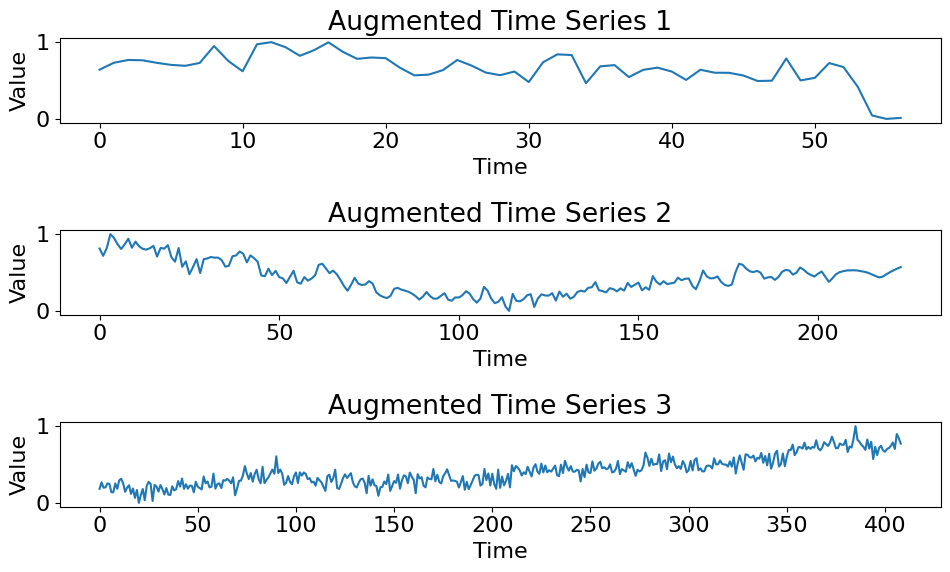

In [ ]:
#plot to see everything went well

k = 3

# Randomly select k indices for plotting
random_indices = np.random.choice(len(augmented_data), k, replace=False)

# Plot the two randomly selected augmented time series with valid periods
plt.figure(figsize=(10, 6))

for i, idx in enumerate(random_indices, 1):
    plt.subplot(k, 1, i)
    valid_start, valid_end = augmented_valid_periods[idx]
    plt.plot(augmented_data[idx, valid_start:valid_end])
    plt.title(f'Augmented Time Series {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()